In [41]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [46]:
#1. SETUP & DATA CLEANING
#Ignore warnings to keep presentation clean
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

#Load and sort data to ensure time-series consistency
df = pd.read_csv('data/all_stocks_5yr.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['Name','date'])

#Data cleaning
df = df.ffill()

In [47]:
#2. FEATURE ENGINEERING
#Calculate daily percentage returns
df['daily_return'] = df.groupby('Name')['close'].pct_change()

print('\nData Preview:')
print(df.head())


Data Preview:
            date   open   high    low  close   volume Name  daily_return
71611 2013-02-08  45.07  45.35  45.00  45.08  1824755    A           NaN
71612 2013-02-11  45.17  45.18  44.45  44.60  2915405    A     -0.010648
71613 2013-02-12  44.81  44.95  44.50  44.62  2373731    A      0.000448
71614 2013-02-13  44.81  45.24  44.68  44.75  2052338    A      0.002913
71615 2013-02-14  44.72  44.78  44.36  44.58  3826245    A     -0.003799


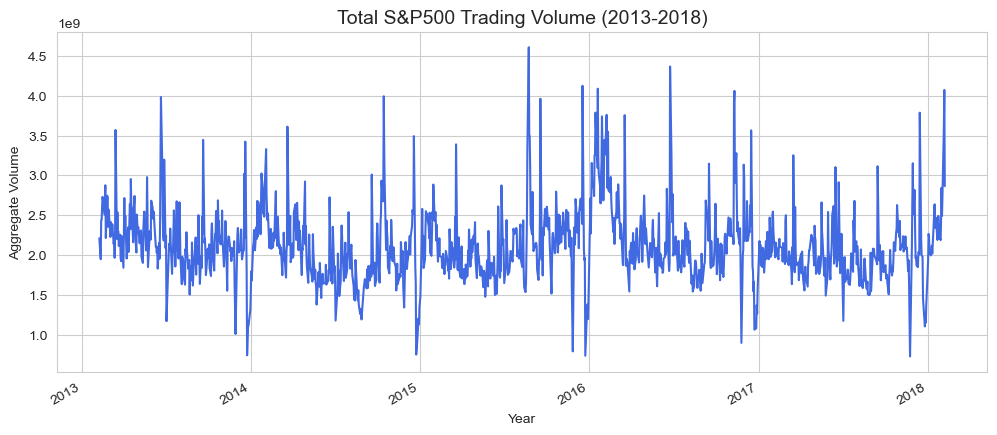

In [48]:
#3. MARKET-WIDE EDA
plt.figure(figsize=(12,5))
df.groupby('date')['volume'].sum().plot(color='royalblue',lw=1.5)
plt.title('Total S&P500 Trading Volume (2013-2018)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Aggregate Volume')
plt.show()

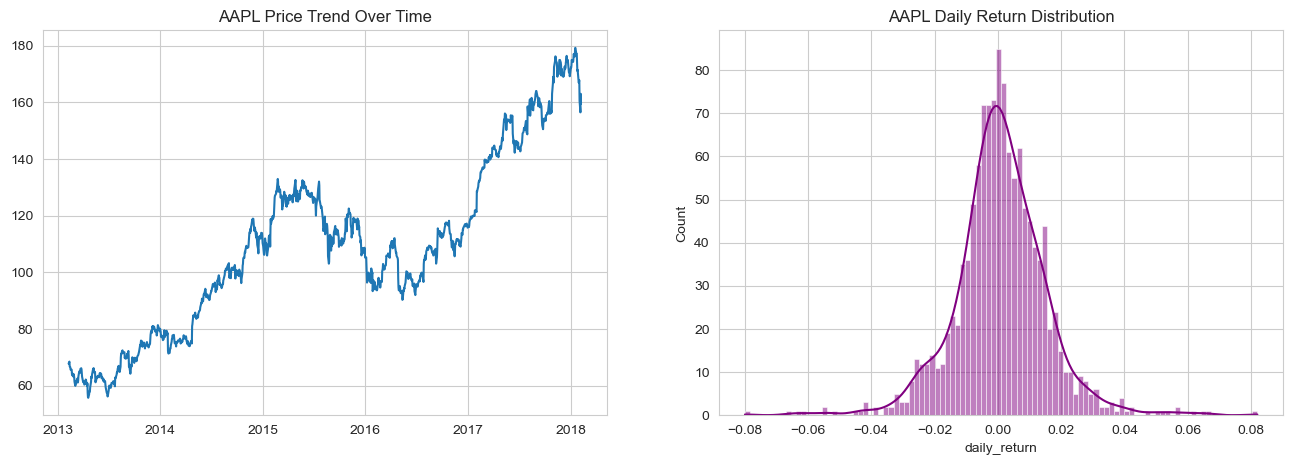

In [51]:
#4. INDIVIDUAL STOCK ANALYSIS (AAPL)
name = 'AAPL'
df_name = df[df['Name'] == name].copy()
df_name['volatility'] = df_name['daily_return'].rolling(window=30).std()

fig,ax = plt.subplots(1,2,figsize=(16,5))

#Price Trend
ax[0].plot(df_name['date'], df_name['close'], color='tab:blue')
ax[0].set_title(f'{name} Price Trend Over Time', fontsize=12)

                      
#Return Distribution
sns.histplot(df_name['daily_return'].dropna(), bins=100, kde=True, ax=ax[1], color='purple')
ax[1].set_title(f'{name} Daily Return Distribution', fontsize=12)
plt.show()


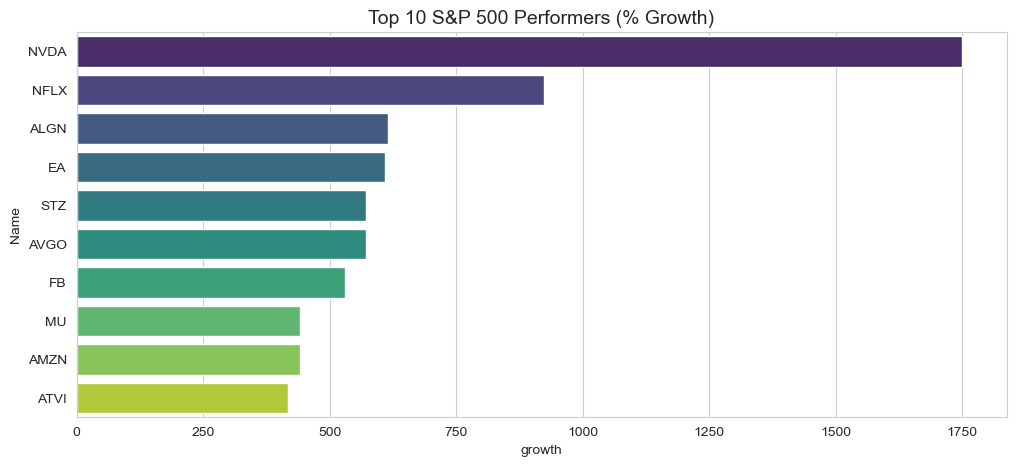

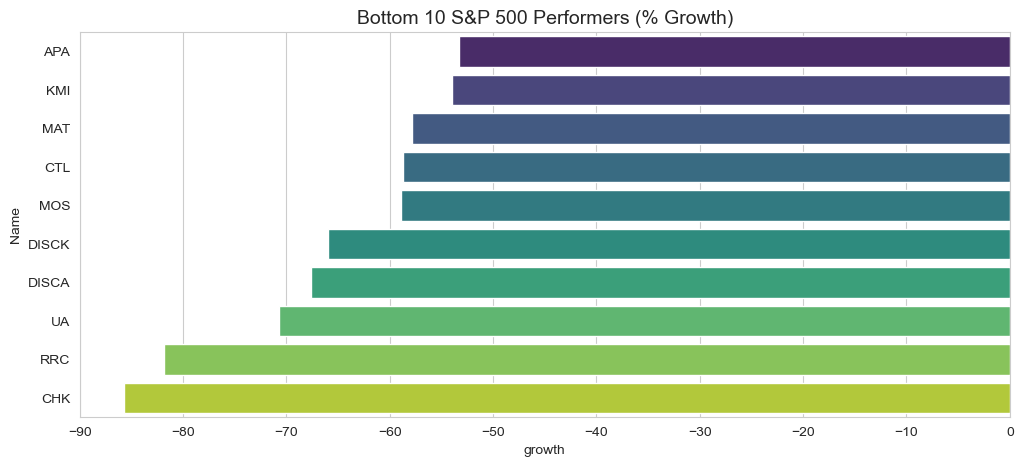

In [53]:
#5. CUMULATIVE GROWTH: WINNERS VS LOSERS
#Apply the formula: (Final Price / Initial Price) - 1
performance = df.groupby('Name')['close'].agg(['first', 'last'])
performance['growth'] = (performance['last'] - performance['first']) / performance['first'] * 100

top_10 = performance.sort_values(by='growth', ascending=False).head(10)
bottom_10 = performance.sort_values(by='growth', ascending=False).tail(10)

#Visualising Top 10
plt.figure(figsize=(12, 5))
sns.barplot(x=top_10['growth'], y=top_10.index, hue=top_10.index, palette='viridis', legend=False)
plt.title('Top 10 S&P 500 Performers (% Growth)', fontsize=14)
plt.show()

#Visualising Bottom 10
plt.figure(figsize=(12, 5))
sns.barplot(x=bottom_10['growth'], y=bottom_10.index, hue=bottom_10.index, palette='viridis', legend=False)
plt.title('Bottom 10 S&P 500 Performers (% Growth)', fontsize=14)
plt.show()

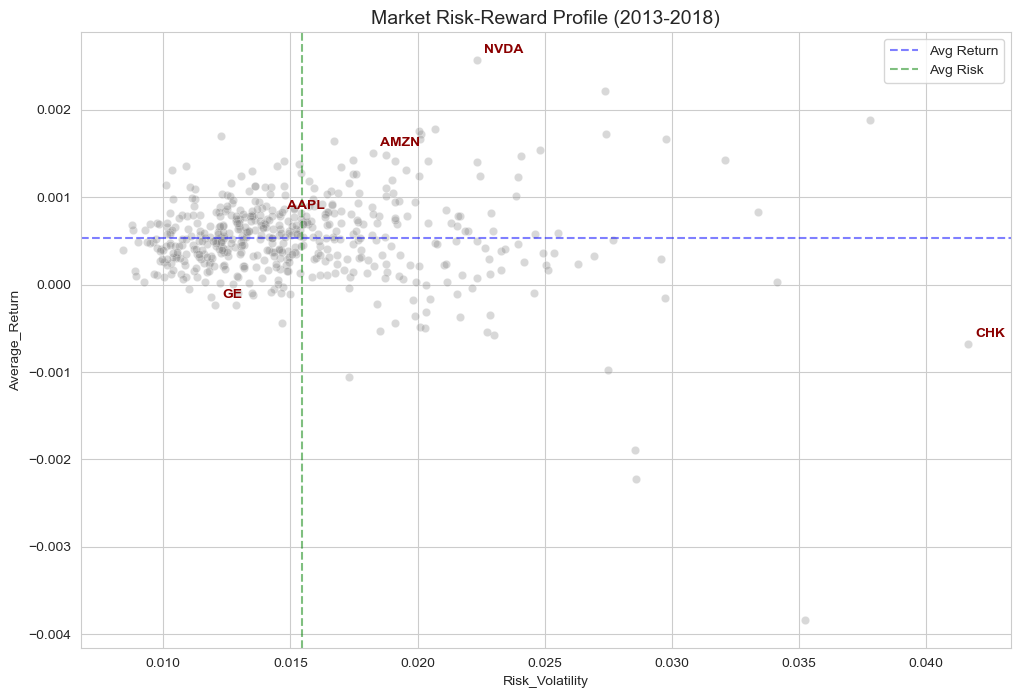

In [55]:
#6. RISK VS REWARD ANALYSIS
summary = df.groupby('Name')['daily_return'].agg(['mean', 'std']).dropna()
summary.columns = ['Average_Return', 'Risk_Volatility']

#Identify Efficient Stocks (Threshold Analysis)
avg_risk = summary['Risk_Volatility'].mean()
avg_return = summary['Average_Return'].mean()
efficient_stocks = summary[(summary['Average_Return'] > avg_return) & (summary['Risk_Volatility'] < avg_risk)]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=summary, x='Risk_Volatility', y='Average_Return', alpha=0.3, color='gray')

#Highlighting Outliers & Efficient Performers
for t in ['AAPL', 'AMZN', 'NVDA', 'GE', 'CHK']:
    if t in summary.index:
        plt.annotate(t, (summary.loc[t, 'Risk_Volatility'], summary.loc[t, 'Average_Return']), 
                     weight='bold', color='darkred', xytext=(5,5), textcoords='offset points')

plt.axhline(avg_return, color='blue', linestyle='--', alpha=0.5, label='Avg Return')
plt.axvline(avg_risk, color='green', linestyle='--', alpha=0.5, label='Avg Risk')
plt.title('Market Risk-Reward Profile (2013-2018)', fontsize=14)
plt.legend()
plt.show()


In [59]:
#7. Executive Insight Calculation

#Calculate Average Volatility (Risk) for both groups
top_vol = summary.loc[top_10.index, 'Risk_Volatility'].mean()
bottom_vol = summary.loc[bottom_10.index, 'Risk_Volatility'].mean()

#Calculate Average Daily Return for both groups
top_ret = summary.loc[top_10.index, 'Average_Return'].mean()
bottom_ret = summary.loc[bottom_10.index, 'Average_Return'].mean()

print("--- EXECUTIVE SUMMARY METRICS ---")
print(f"Winners Avg Daily Return: {top_ret:.4%}") 
print(f"Losers Avg Daily Return: {bottom_ret:.4%}") 
print(f"Winners Avg Volatility: {top_vol:.4f}")   
print(f"Losers Avg Volatility: {bottom_vol:.4f}")

--- EXECUTIVE SUMMARY METRICS ---
Winners Avg Daily Return: 0.1804%
Losers Avg Daily Return: -0.0729%
Winners Avg Volatility: 0.0212
Losers Avg Volatility: 0.0244


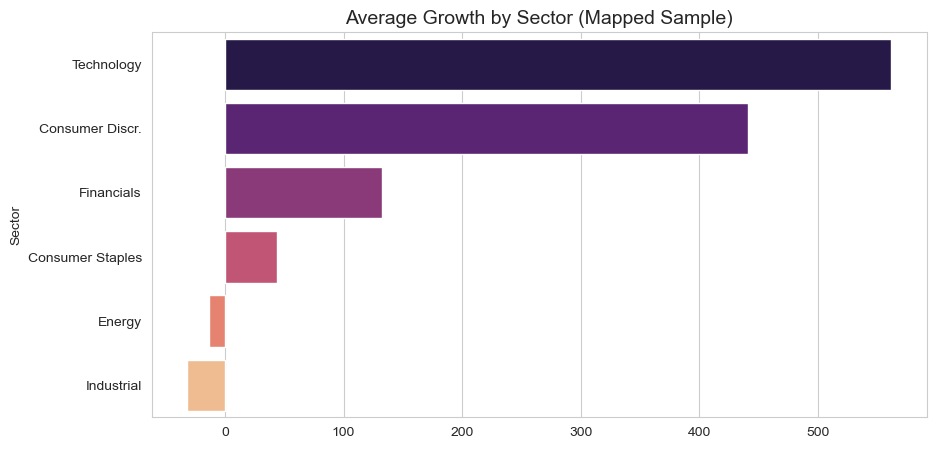

In [60]:
#8. SECTOR ANALYSIS
sector_map = {
    'AAPL': 'Technology', 'MSFT': 'Technology', 'AMZN': 'Consumer Discr.',
    'GE': 'Industrial', 'XOM': 'Energy', 'JPM': 'Financials', 'WMT': 'Consumer Staples',
    'NVDA': 'Technology', 'FB': 'Technology', 'GOOGL': 'Technology'
}

performance['Sector'] = performance.index.map(sector_map)
sector_growth = performance.groupby('Sector')['growth'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=sector_growth.values, y=sector_growth.index, hue=sector_growth.index, palette='magma', legend=False)
plt.title('Average Growth by Sector (Mapped Sample)', fontsize=14)
plt.show()

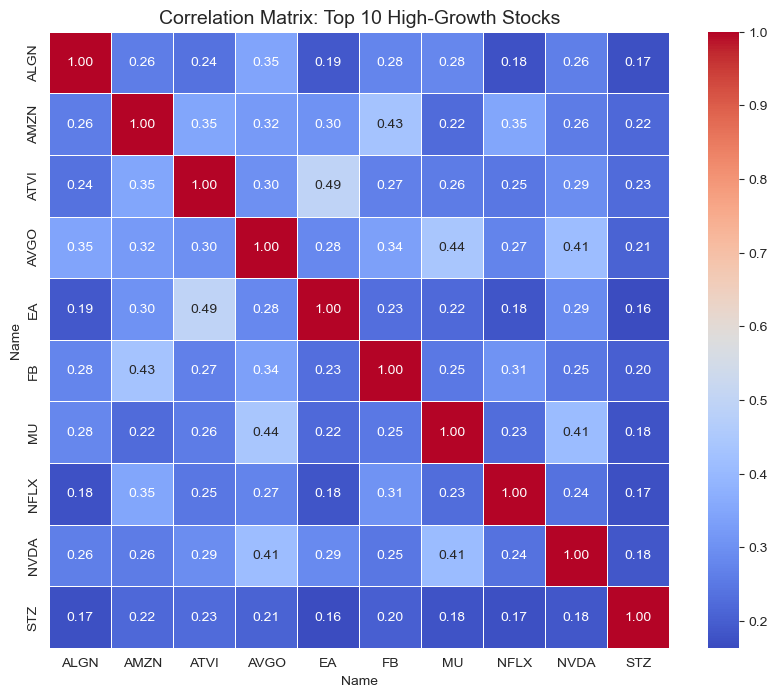

Analysis Complete.


In [58]:
#8. CORRELATION ANALYSIS
top_10_tickers = top_10.index.tolist()
pivot_df = df[df['Name'].isin(top_10_tickers)].pivot(index='date', columns='Name', values='close')
corr_matrix = pivot_df.pct_change().corr()

#Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Top 10 High-Growth Stocks', fontsize=14)
plt.show()

print("Analysis Complete.")